In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pathlib
import os
from tensorflow.keras.models import load_model

2025-05-06 10:16:27.060896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 10:16:27.069633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746515787.079281   38532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746515787.081978   38532 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746515787.089570   38532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [27]:
# Параметри
# LOW_RES = 16
# HIGH_RES = 64
HIGH_RES = 128
LOW_RES = 32
BATCH_SIZE = 32
EPOCHS = 20
DATA_PATH = 'data/my_dataset/img/unknown'  # папка з фото


In [28]:
# Обробка зображення
def preprocess(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)

    high_res = tf.image.resize(img, [HIGH_RES, HIGH_RES])
    high_res = tf.cast(high_res, tf.float32) / 255.0

    low_res = tf.image.resize(img, [LOW_RES, LOW_RES])
    low_res = tf.image.resize(low_res, [HIGH_RES, HIGH_RES])
    low_res = tf.cast(low_res, tf.float32) / 255.0

    return low_res, high_res



In [29]:
# Завантаження локального датасету
all_files = list(pathlib.Path(DATA_PATH).rglob("*.jpg"))  # або .png
file_paths = tf.data.Dataset.from_tensor_slices([str(p) for p in all_files])

# shuffle і split
file_count = len(all_files)
train_size = int(file_count * 0.8)
ds_train = file_paths.take(train_size).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = file_paths.skip(train_size).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



I0000 00:00:1746515877.506981   38532 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1290 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [30]:
# Побудова моделі Face Hallucination

def build_model():
    inputs = layers.Input(shape=(HIGH_RES, HIGH_RES, 3))  # Вхід: upsampled low-res
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)  # output RGB
    return models.Model(inputs, x)

In [31]:
model = build_model()

model = load_model("face_hallucination_model.h5", compile=False)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Тренування моделі
# model.fit(ds_train, epochs=EPOCHS, validation_data=ds_test)

# Збереження моделі
model.save("face_hallucination_model_2.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,051 (226.76 KB)

 Trainable params: 58,051 (226.76 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


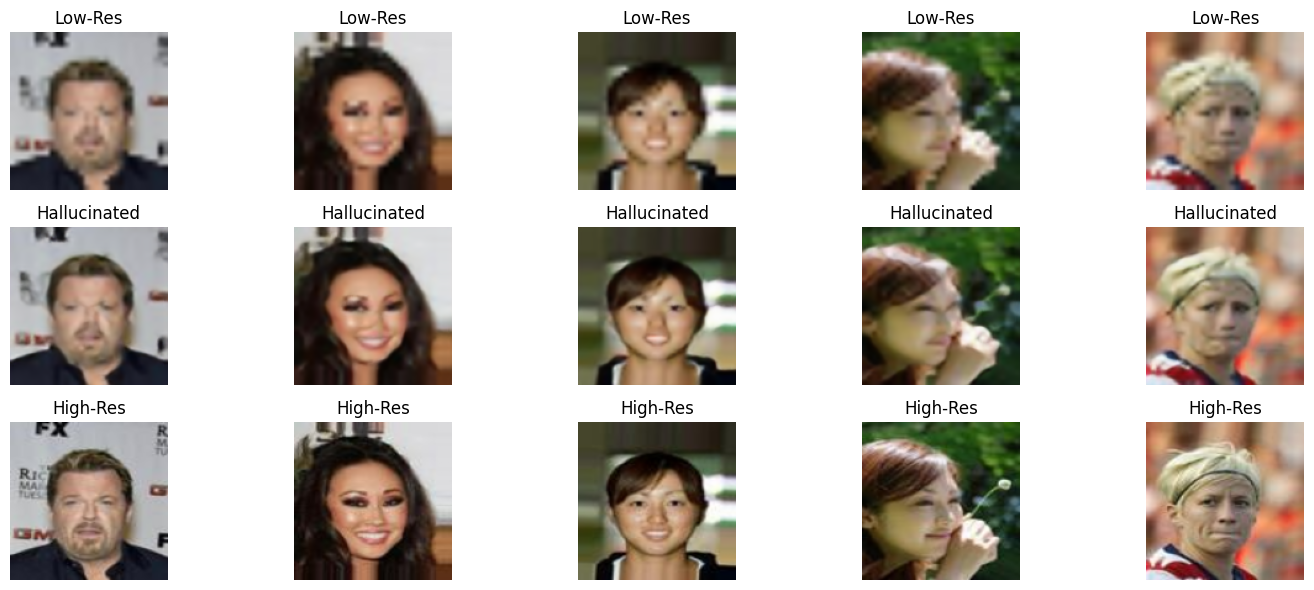

2025-05-06 10:21:42.604236: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
# After 20 epoch
# Отримуємо один batch з тестового датасету
for low_res_batch, high_res_batch in ds_test.take(1):
    preds = model.predict(low_res_batch)

    # Відображаємо перші 5 зображень
    num_samples = 5
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        # Low-res (input)
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(low_res_batch[i].numpy())
        plt.title("Low-Res")
        plt.axis("off")

        # Hallucinated (output)
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(preds[i])
        plt.title("Hallucinated")
        plt.axis("off")

        # High-res (ground truth)
        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(high_res_batch[i].numpy())
        plt.title("High-Res")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,051 (226.76 KB)

 Trainable params: 58,051 (226.76 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


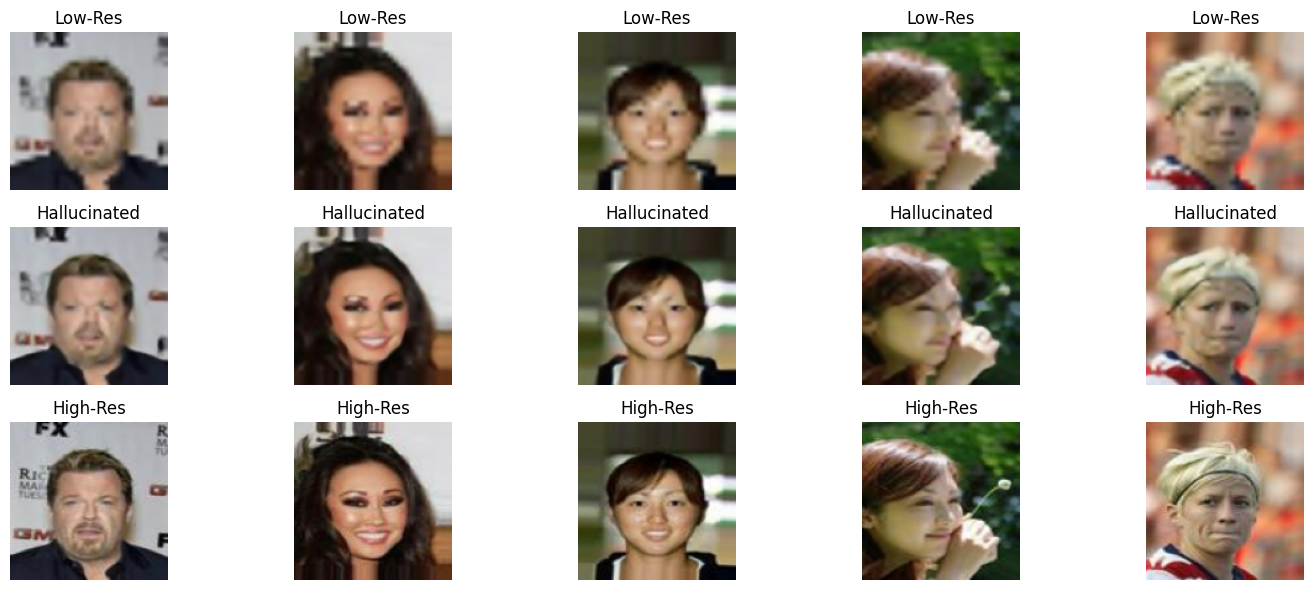

In [34]:
# After 40 epoch
model = load_model("face_hallucination_model_2.h5", compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
for low_res_batch, high_res_batch in ds_test.take(1):
    preds = model.predict(low_res_batch)

    # Відображаємо перші 5 зображень
    num_samples = 5
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        # Low-res (input)
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(low_res_batch[i].numpy())
        plt.title("Low-Res")
        plt.axis("off")

        # Hallucinated (output)
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(preds[i])
        plt.title("Hallucinated")
        plt.axis("off")

        # High-res (ground truth)
        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(high_res_batch[i].numpy())
        plt.title("High-Res")
        plt.axis("off")

    plt.tight_layout()
    plt.show()